# Phân loại các phương tiện giao thông sử dụng SVM

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pickle

In [2]:
def load_image(image_path):
    return cv2.imread(image_path)

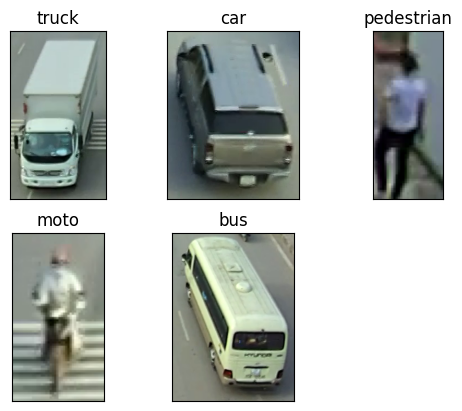

In [3]:
samples_list = []
samples_label = []

for label in os.listdir('vehicle/Training'):
    sample_file = os.listdir(os.path.join('vehicle/Training', label))[0]
    
    samples_list.append(load_image(os.path.join('vehicle/Training', label, sample_file)))
    
    samples_label.append(label)
    
for i in range(len(samples_list)):
    plt.subplot(2, 3, i + 1), plt.imshow(cv2.cvtColor(samples_list[i], cv2.COLOR_BGR2RGB))
    plt.title(samples_label[i]), plt.xticks([]), plt.yticks([])
    


In [4]:
def read_data(dir):
    X = []
    y = []
    label_int = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}

    for label in os.listdir(dir):
        for image_file in os.listdir(os.path.join(dir, label)):
            X.append(load_image(os.path.join(dir, label, image_file)))
            y.append(label_int[label])

    return X, y

In [5]:
X_train, y_train = read_data('vehicle/Training')

## Trích chọn đặc trưng.
Sử dụng Phương pháp BoW cho computer vision:
- Chia nhỏ ảnh thành patches (các ảnh nhỏ hình chữ nhật)
- Gộp các patches gần giống nhau lại thành 1 nhóm (các patches gần giống nhau nếu có khoảng các euclid gần nhau)
- Sử dụng K-means để gom nhóm các patches 

### 1. Trích xuất đặc trưng sử dụng SIFT


In [6]:
def extract_sift_features(X):
    image_des = []
    sift = cv2.SIFT_create()
    
    for img in X:
        _,des = sift.detectAndCompute(img, None)
        image_des.append(des)
    return image_des

In [7]:
image_descriptors = extract_sift_features(X_train)
print(len(image_descriptors))
print(type(image_descriptors[0][0]))
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

1672
<class 'numpy.ndarray'>
Image 0 has 144 descriptors
Image 1 has 233 descriptors
Image 2 has 244 descriptors
Image 3 has 740 descriptors
Image 4 has 168 descriptors
Image 5 has 800 descriptors
Image 6 has 46 descriptors
Image 7 has 127 descriptors
Image 8 has 100 descriptors
Image 9 has 50 descriptors


In [8]:
def get_all_descriptors(image_descriptors):
    all_descriptors = []
    for descriptors in image_descriptors:
        if descriptors is not None:
            for des in descriptors:
                all_descriptors.append(des)
    
    return all_descriptors

In [9]:
## Lấy đặc điểm của tất cả các ảnh
all_descriptors = get_all_descriptors(image_descriptors)

In [10]:
image_descriptors[0].shape

(144, 128)

sử dụng thuật toán KMeans trong scikit-learn phân cụm các vector descriptors này thành num_clusters cụm. Hàm trả về một danh sách center của các cụm. 

In [11]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []

    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    return bow_dict

In [12]:
num_clusters = 150

BoW = kmeans_bow(all_descriptors, num_clusters)

In [13]:
from scipy.spatial.distance import cdist

### Xây dựng vector đặc trưng với mô hình BoW

In [14]:
def create_features_bow(image_descriptors, bow, num_cluster):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.zeros(num_cluster)

        if (image_descriptors[i] is not None):
            distance = cdist(image_descriptors[i], bow)
            
            argmin = np.argmin(distance, axis=1)
            for j in argmin:
                features[j] += 1
        X_features.append(features)
    return X_features

## Xây dựng mô hình


In [15]:
X_feature = create_features_bow(image_descriptors, BoW, num_clusters)

In [24]:
import sklearn

svm = sklearn.svm.SVC(C = 30)

svm.fit(X_feature, y_train)

SVC(C=30)

Độ chính xác trên tập train

In [25]:
svm.score(X_feature, y_train)

0.9988038277511961

Độ chính xác trên tập test

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
X_test, y_test = read_data('vehicle/Testing')

In [28]:
X_feature_test = create_features_bow(extract_sift_features(X_test), BoW, num_clusters)

In [29]:
y_pred = svm.predict(X_feature_test)
accuracy_score(y_pred, y_test)

0.6939890710382514

In [30]:
from sklearn.ensemble import AdaBoostClassifier


model = AdaBoostClassifier()
model.fit(X_feature, y_train)

y_pred = model.predict(X_feature_test)
accuracy_score(y_pred, y_test)

/home/vang/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.4972677595628415

In [31]:
from xgboost import XGBClassifier
model = XGBClassifier()

model.fit(X_feature, y_train)

y_pred = model.predict(X_feature_test)
accuracy_score(y_pred, y_test)

0.7103825136612022

### Tối ưu hóa tham số

In [36]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
models = {'SVC' : SVC(),
          'XGBClassifier': XGBClassifier()}

param_grid = {'SVC': {'C' : [20, 30, 40, 50],
                      'kernel': ['poly', 'linear', 'rbf'],
                      'degree': [8, 10, 15]},

                'XGBClassifier': {'learning_rate': [0.15],
                        'max_depth': [8, 10, 12],
                        'min_child_weight': [3, 5, 7],
                        'subsample': [1, 0.9, 0.8],
                        'n_estimators': [100, 200, 300]}
                }



In [38]:
for model_name in models.keys():
    model = models.get(model_name)
    param = param_grid.get(model_name)

    grid = GridSearchCV(model, param_grid=param)
    grid.fit(X_feature, y_train)

    best_model = grid.best_estimator_
    best_model.fit(X_feature, y_train)

    y_pred = best_model.predict(X_feature)
    print('best model', model_name,'accuracy train: ', accuracy_score(y_pred, y_train))

    y_pred = best_model.predict(X_feature_test)
    print('best model', model_name,'accuracy test: ', accuracy_score(y_pred, y_test))

best model SVC accuracy train:  0.9982057416267942
best model SVC accuracy test:  0.6885245901639344
best model XGBClassifier accuracy train:  1.0
best model XGBClassifier accuracy test:  0.6939890710382514
